# TM07 embedding and clustering

在做文本聚類（Document Clustering）的時候，即使抽出每個文本的關鍵字，也有可能會有聚類效果不好（群與群之間分不開）的情形。這其中一種可能的原因是文本中有非常多意義相近或類型相近的名詞，但在計算的時候被視為不同的文字。例如在政治類文本中的「小英」或「蔡英文」意指同一個人，但在計算上就是兩個相異詞；又如下列兩個句子，叉燒和豆花都是一種食品，在句子中的位置非常接近，但如果就以抽關鍵字與文字作為特徵向量的方法來做文件比對，這就是兩個完全相異的詞。所以，我們想要找到一種方法，能夠讓「叉燒」和「豆花」這兩個字的表徵「Representation」相近一些。
* 這家的「叉燒」不好吃
* 這家的招牌「豆花」令人感到失望

「詞嵌入（Word embeddings）」的想法是，從上面兩句話來看，可以發現「叉燒」與「豆花」兩個字周遭的句法結構是非常接近的，而且主要是「店家+食品+評價」的句法結構。所以，可以嘗試把「叉燒」或「豆花」周遭的文字作為該詞的表徵（除了自己本身以外），這也可以簡單地說是一個詞出現的脈絡。如果可以用這樣的方式表徵「叉燒」與「豆花」，那自然「店家」或「評價」也可以被這樣表徵，同時就克服了「叉燒」與「豆花」周遭的文字也有可能會有意思相近的情形。

詞嵌入：將一個詞周遭一定範圍內的字詞（除了該詞本身）作為該詞的表徵。


## Process 

整體過程如下圖：
1. 從一個文本有哪些字中，會建立一出每個字周遭w個字作為其脈絡的矩陣，亦即以周遭文字為特徵的term-term matrix。
2. 之後會將該矩陣轉為一個等長的向量矩陣，每個字的周遭脈絡轉為300維。前兩個步驟為詞嵌入的過程，一般來說會是用word2vec的演算法做，抽取預測下一個字詞的第一層節點的權重來作為向量。
3. 根據每篇文章有哪些詞，挑選（或不挑選）TF-IDF的向量做加總（為向量運算，加總後要除以加總的向量數）。
4. 可得到每篇文章的向量。該向量長度會等於前面的文字向量。
5. 這些向量就是該篇文章的特徵，就類似原本的群集法一樣，把每篇文章有哪些文字當作其特徵。有了這些特徵後，就可以往下做Clustering。

![Alt text](img/TM07_1.png)

## Loading data

這邊用作範例的資料仍然是在[TM06 Clustering](tm06:clustering)所使用的評價留言。之前透過TF-IDF抽取關鍵字在群集的效果並不好，希望這個例子可以有所改善。

In [1]:
# !mkdir ./data
# !wget -P ./data -N https://github.com/p4css/py4css/raw/main/data/sentiment.csv

In [2]:
import pandas as pd
df = pd.read_csv('data/sentiment.csv')

import jieba
df['token_text'] = df['text'].apply(lambda x:list(jieba.cut(x)))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/j3/p4x0mssx55nd8dn903h5wdb00000gn/T/jieba.cache
Loading model cost 0.284 seconds.
Prefix dict has been built successfully.


,tag,text,token_text
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是..."


## Term frequency

### Loading stopwords

In [3]:
# !wget https://raw.githubusercontent.com/p4css/py4css/main/data/sentiment.csv -O stopwords_zh-tw.txt 
# !wget https://raw.githubusercontent.com/p4css/py4css/main/data/sentiment.csv -P data/

with open("data/stopwords_zh-tw.txt", encoding="utf-8") as fin:
    stopwords = fin.read().split("\n")[1:]
print("stop words: ", stopwords[:100])
print(len(stopwords))

def remove_stopWords(words):
    out = []
    for word in words:
        if word not in stopwords:
            out.append(word)
    return out


import unicodedata # for removing Chinese puctuation
def remove_punc_by_unicode(words):
    out = []
    for word in words:
        if word != " " and not unicodedata.category(word[0]).startswith('P'):
            out.append(word)
    return out

df['cleaned'] = df['token_text'].apply(remove_stopWords)
df['cleaned'] = df['cleaned'].apply(remove_punc_by_unicode)
# for i in range(df.shape[0]):
#     if len(df['cleaned'][i]) == 0:
#         df['cleaned'][i] = df['token_text'][i]
df.head()


stop words:  ['?', '、', '。', '“', '”', '《', '》', '！', '「', '」', '『', '』', '，', '：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少']
1212


,tag,text,token_text,cleaned
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]","[店家, 給力, 快遞, 相當快, 第三次, 光顧]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,...","[配置, Vista, 系統, 有點, 卡, 指紋, 收集器, 沒送, 原裝, 滑鼠, 需要..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]","[不錯, 同等, 檔次, 酒店, 中應, 值得, 推薦]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]","[蒙牛, 乾, 嚴懲, 真凶]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是...","[空, 尤其, 三立, 電視, 臺, 女主播, 做, 序, 尤其, 無趣, 像是, 硬, 湊..."


### Detecting Chinese punctuation

以下先觀察資料的詞頻（依照高至低排列）

In [5]:
# Take a look at the most common words (from high to low)
from collections import Counter
word_count = Counter([tok for tokens in df['cleaned'] for tok in tokens if len(tok) > 1])
for k, v in word_count.most_common(10):
    print(k, '\t', v)

蒙牛 	 1556
不錯 	 907
酒店 	 385
房間 	 366
感覺 	 350
外觀 	 294
系統 	 276
價格 	 269
價效 	 262
螢幕 	 258


## Building word2vec model
- Reference: https://radimrehurek.com/gensim/models/word2vec.html

### Building model

- `vector_size`: 每個詞要表徵為多少維度的向量
- `window`: 每個詞的表徵要納入前後多少個詞。

In [274]:
from gensim.models import Word2Vec
model = Word2Vec(df['token_text'], min_count=1, vector_size=300, window=10, sg=0, workers=4)

### Testing Similarity
- Number of dimensions of the NumPy array: `.ndim`
- Shape of the NumPy array: `.shape`
- Size of the NumPy array: `.size`
- Size of the first dimension of the NumPy array: `len()`


In [275]:
print(model.wv["火鍋"].shape)
print(model.wv["火鍋"].size)
print(model.wv["火鍋"].ndim)
print(len(model.wv["火鍋"]))
model.wv["蒙牛"]

(300,)
300
1
300


array([-0.31674013,  0.98479056,  0.55002797, -0.00300632, -0.3717087 ,
       -0.03676438,  0.80388683,  1.6157628 ,  0.40359935, -1.0496926 ,
        0.8474335 , -0.20636885, -0.06867974, -0.5290617 , -0.64192927,
       -1.4889965 ,  0.14241537, -0.79011923,  0.5477932 , -0.15136261,
        0.18019041,  0.25337672,  0.45982563,  0.09620805,  0.9149604 ,
       -0.32965535, -1.1101619 ,  0.57151294, -0.65307313, -1.1042819 ,
       -0.75969183,  0.03025471,  0.6332594 , -0.46678978,  0.15717323,
        0.44125384,  0.9859078 , -0.858264  , -0.78866714, -0.21589145,
       -0.15076241,  0.7403064 ,  0.18195632, -0.7552988 ,  0.670244  ,
        0.66446006,  0.7908314 ,  0.19624071, -0.21637331,  0.7410341 ,
        0.2018969 ,  0.11659689, -1.1713946 ,  1.0404803 , -0.48892394,
        0.24101909,  0.6852858 , -0.80667424, -0.15899062,  0.10740341,
       -0.6248213 ,  0.69450855, -0.30251327, -0.01447687, -0.44272155,
       -0.034931  ,  0.0795709 ,  0.378609  , -0.01827897, -0.63

In [276]:
#  他 : 工程師 = 她 : ?
print(model.wv.most_similar(["火鍋", "好吃"], ["廁所"], topn=20))
print("-"*40)
#  他 : 醫師 = 她 : ?
print(model.wv.most_similar(["鍵盤", "工具"], ["垃圾"], topn=20))

[('來安裝', 0.9180076122283936), ('好評', 0.9177042841911316), ('貴', 0.9163232445716858), ('還沒安裝', 0.9159592390060425), ('真的', 0.9159547686576843), ('哦', 0.9159358143806458), ('c', 0.915668785572052), ('遞', 0.9155442714691162), ('呵呵', 0.9154207110404968), ('包裝', 0.9153860211372375), ('喜歡', 0.9153680205345154), ('保障', 0.9153565168380737), ('新', 0.9152351021766663), ('遺憾', 0.9152233004570007), ('今晚', 0.9151896238327026), ('吧', 0.91505366563797), ('回來', 0.9150165915489197), ('一瓶', 0.9149009585380554), ('送到', 0.9148070812225342), ('很難', 0.9147375822067261)]
----------------------------------------
[('乾淨', 0.9076069593429565), ('不錯', 0.90566086769104), ('較', 0.9039303660392761), ('比', 0.9032891392707825), ('價效', 0.9023041129112244), ('高', 0.9013342261314392), ('環境', 0.901299238204956), ('外觀', 0.9012528657913208), ('交通', 0.9009637236595154), ('比比', 0.8986650705337524), ('精細', 0.89838045835495), ('足夠', 0.8979520201683044), ('舒適', 0.8975657820701599), ('很', 0.8970848321914673), ('手感', 0.89684182405

## Visualized with Dimension reduction
- [Matplotlib顯示中文問題: Win](https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b)
- [Using Chinese Characters in Matplotlib](https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7)

In [277]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(24, 16)
# 
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = ['Heiti TC']

<Figure size 1728x1152 with 0 Axes>

### Retrieve top 150 to visualize

In [278]:
words = [k for k, v in word_count.most_common(150)]
print(words)
X = []
for word in words:
    X.append(model.wv[word])

['蒙牛', '不錯', '酒店', '房間', '感覺', '外觀', '系統', '價格', '價效', '螢幕', '喜歡', '方便', '有點', '比較', '功能', '服務', '一個', '配置', '問題', '不好', '速度', '時間', '鍵盤', '支援', '知道', '電池', 'XP', '效果', '質量', '還不錯', '驅動', '散熱', '記憶體', '抵制', '東西', '伊利', '漂亮', '滿意', '顯示', '牛奶', '早餐', '收到', '使用', '安裝', '內容', '做工', '效能', '這本書', '便宜', '環境', '很快', '設施', '聲音', '適合', '發現', '手感', '一點', '現在', '容易', '朋友', '光碟', '真的', '硬碟', '已經', '機器', '應該', '覺得', '麻煩', '產品', '好看', '舒服', '電腦', '位置', '值得', '希望', '一下', '入住', '沒什麼', '設計', '特別', '一本', '待機', '執行', '小巧', '很大', '京東', '送貨', '下次', '軟體', '不到', '包裝', '本本', '還行', '很漂亮', '品牌', '真是', '太小', '介面', '需要', '鈴聲', '總體', '推薦', '失望', '攝像頭', '一直', '垃圾', '比高', '手機', '想象', '選擇', '機子', '客服', '交通', '小時', '孩子', '實用', '還算', '呵呵', '相當', '購買', '滑鼠', '只能', '態度', '電話', '晚上', '酸奶', '下載', '味道', '完美', '還好', '看到', '一些', 'xp', '地方', '簡單', '好像', '建議', '太差', '時尚', '服務態度', '方面', '這款', 'vista', '拿到', '同事', '齊全', '外殼', '水器', 'MP3', '噹噹']


### Reduced by PCA

In [279]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
points = pca.fit_transform(X)

points[:20]

array([[ 4.74592759,  6.66997576],
       [ 3.94307783, -2.60163107],
       [ 4.40328159, -1.35683092],
       [ 5.11001776, -2.06241048],
       [ 3.96341292, -0.25232676],
       [ 3.25000117, -1.99057109],
       [ 3.90847063,  0.61370119],
       [ 2.88722208, -1.06897115],
       [ 3.15435492, -2.46605869],
       [ 3.59059089, -0.8162231 ],
       [ 1.28886906,  1.61802887],
       [ 2.73910398, -1.29906524],
       [ 4.44527505,  0.89595956],
       [ 3.6601702 , -1.05660219],
       [ 2.76336013, -0.696953  ],
       [ 2.31693718, -1.28750469],
       [ 3.52185532,  1.5431232 ],
       [ 2.54727455, -1.34922231],
       [ 2.23930328,  1.36073811],
       [ 2.80369536,  0.28384042]])

### Reduced by t-SNE

In [280]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
points = tsne.fit_transform(X) 

points[:20]

/Users/jirlong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jirlong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 3.533635 ,  8.816418 ],
       [ 7.881401 , 11.521997 ],
       [ 8.462722 , 10.540993 ],
       [ 8.62881  , 11.126393 ],
       [ 8.310931 ,  9.248061 ],
       [ 7.2129927, 11.120084 ],
       [ 8.277661 ,  8.218708 ],
       [ 6.891917 , 10.136549 ],
       [ 7.1364975, 11.589076 ],
       [ 7.6893387,  9.757972 ],
       [ 6.0102773,  3.7812707],
       [ 6.610463 , 10.45834  ],
       [ 8.645096 ,  8.1233015],
       [ 7.736853 , 10.236523 ],
       [ 6.7616935,  9.381545 ],
       [ 5.8497934, 10.372941 ],
       [ 8.115181 ,  7.253542 ],
       [ 6.2641997, 10.595124 ],
       [ 6.8710256,  5.9440203],
       [ 7.0219254,  7.9688826]], dtype=float32)

## Plotting

### Plot by matplotlib or seaborn

(-10.220569610595703,
 9.543460845947266,
 -12.77907681465149,
 12.749464273452759)

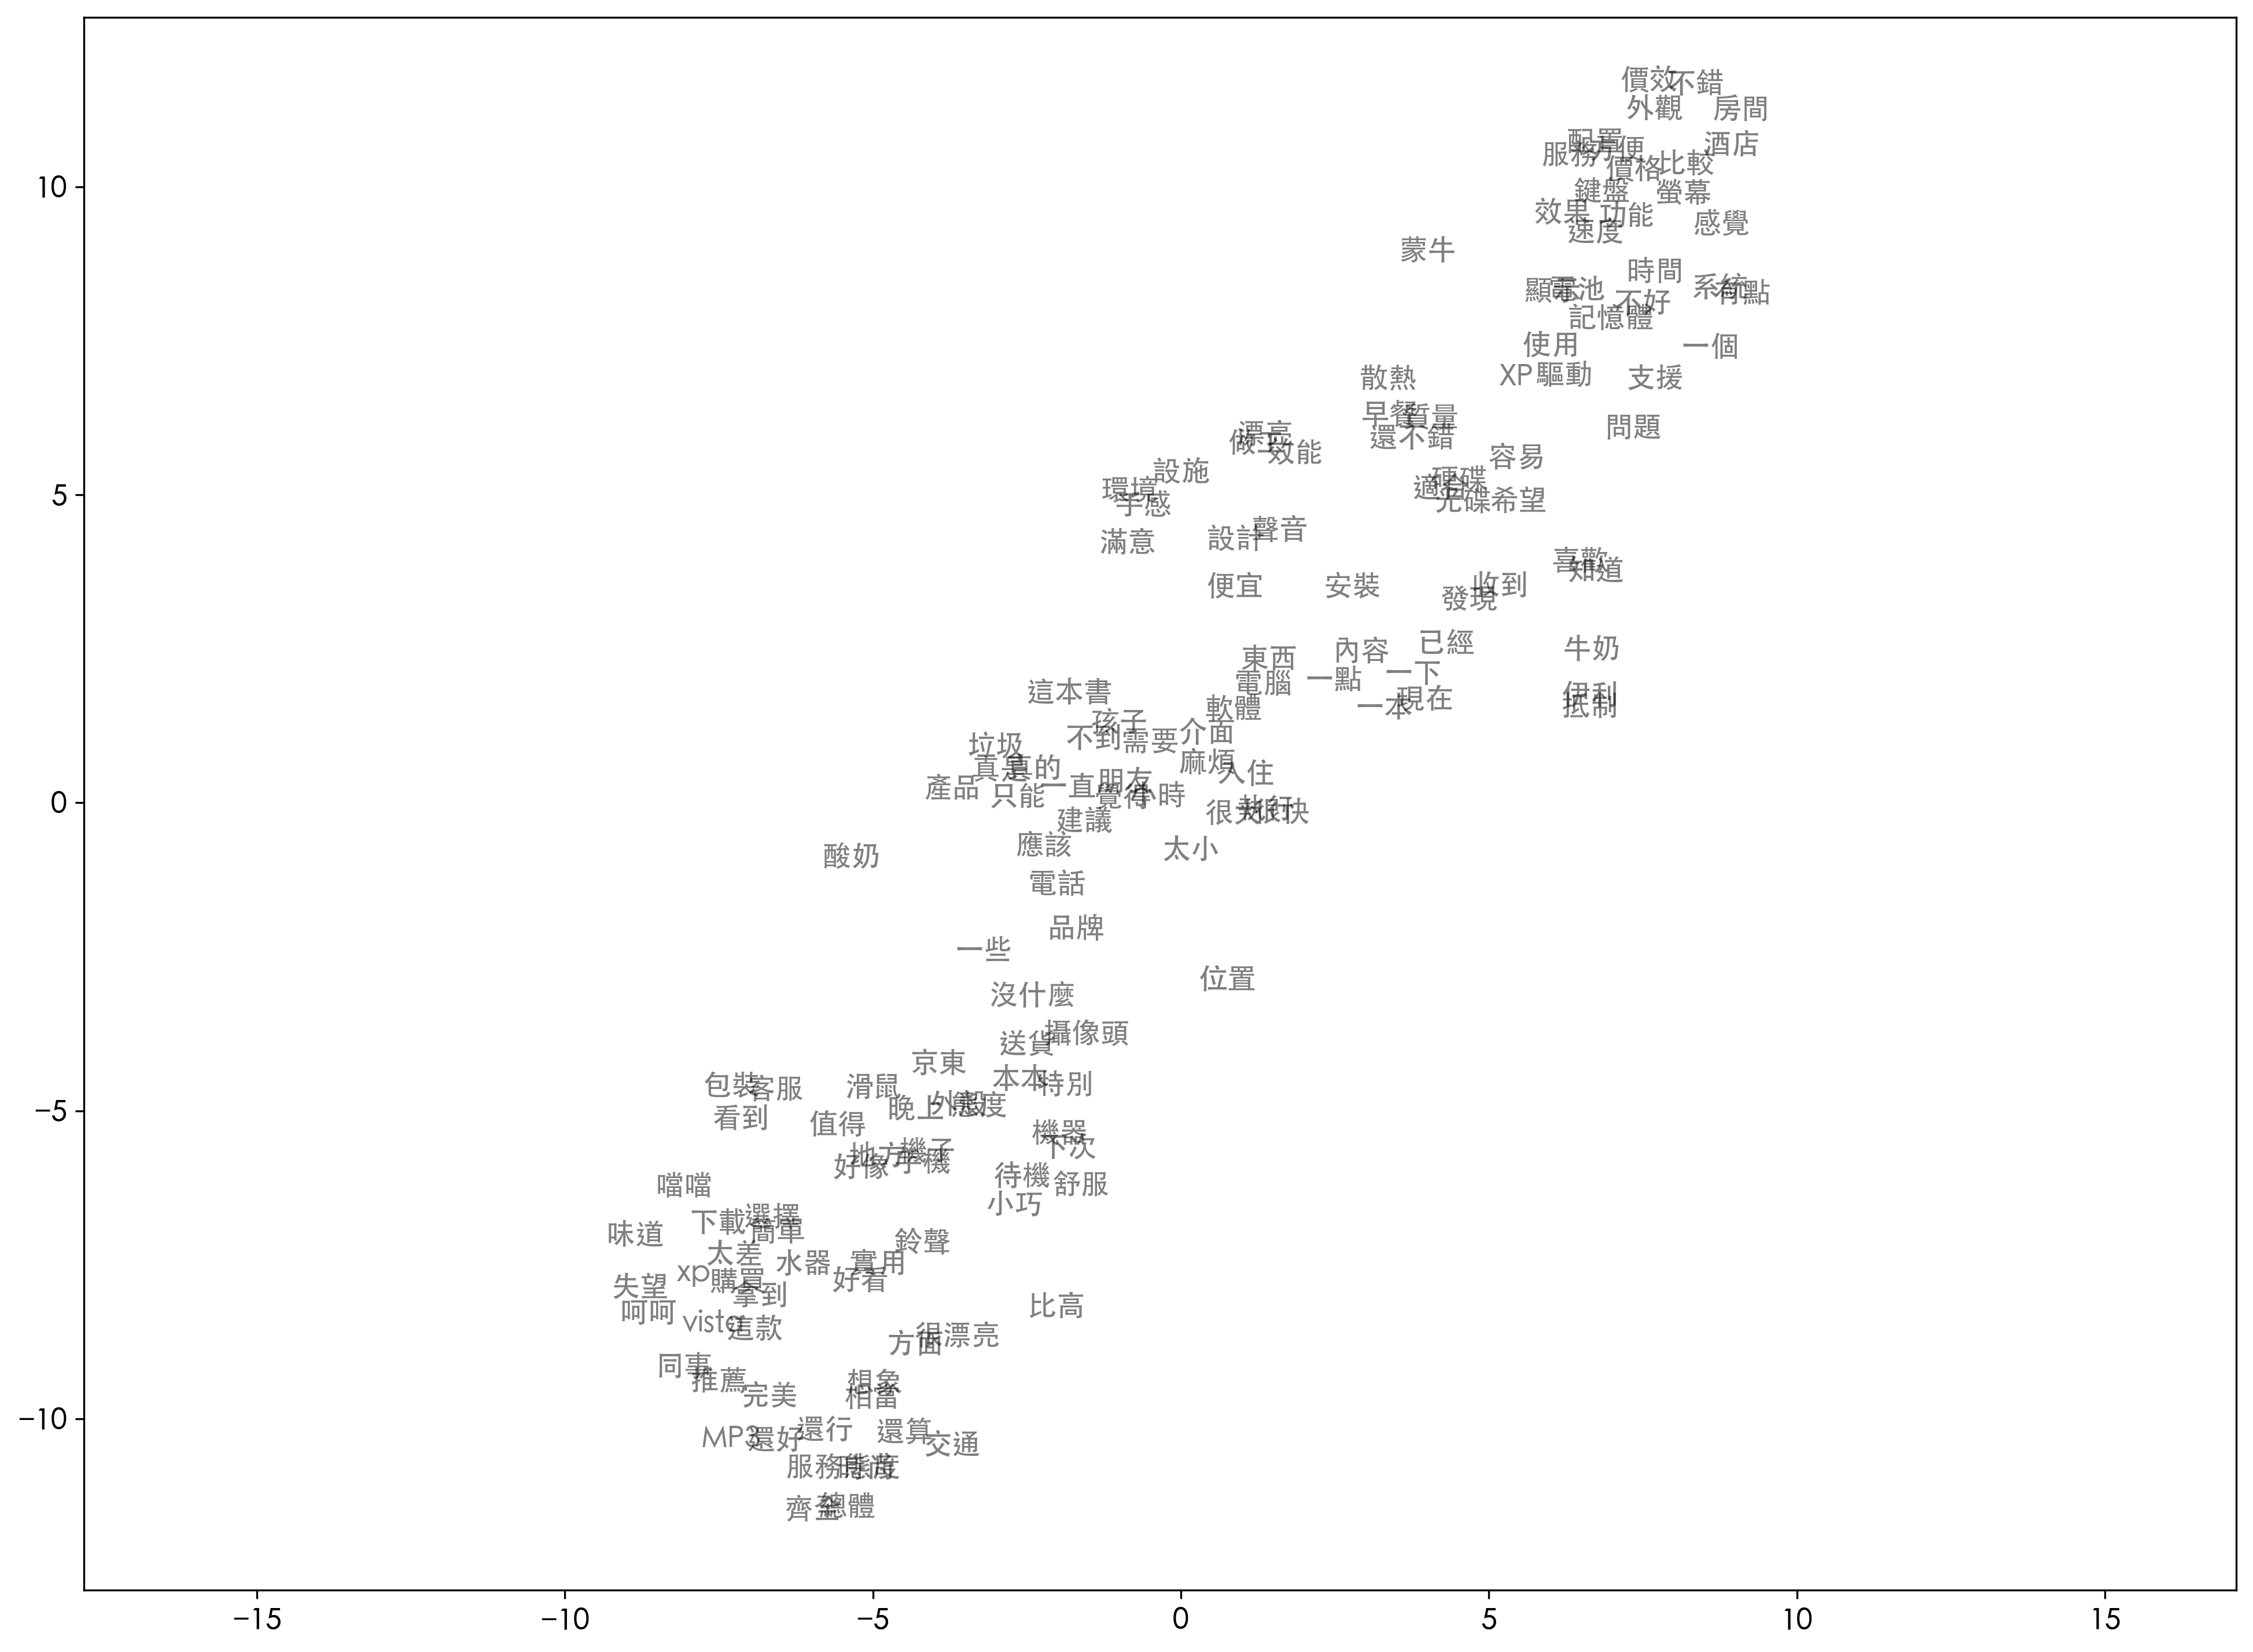

In [281]:
# fig = plt.gcf()
# fig.set_size_inches(24, 16)
plt.figure(figsize=(16, 12), dpi=300) 
# plt.figure(figsize=(8, 6), dpi=300) 
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = ['Heiti TC']
for i in range(len(points)):
    x = points[i][0]
    y = points[i][1]
    plt.scatter(x, y, alpha=0)
    plt.annotate(words[i], xy=(x, y), alpha=0.5)
plt.axis('equal')

### plot by bokeh
- https://stackoverflow.com/questions/40450943/adding-labels-to-a-bokeh-plot
- https://docs.bokeh.org/en/latest/docs/user_guide/annotations.html


In [182]:
import pandas as pd
import numpy as np
scatter = pd.DataFrame(points, columns = ['x', 'y'])
scatter['label'] = words
scatter

,x,y,label
0,3.505675,13.307721,蒙牛
1,-8.033687,-8.971017,不錯
2,-8.605733,-8.072555,酒店
3,-8.688294,-8.623928,房間
4,-5.358955,-3.547830,感覺
...,...,...,...
145,6.062129,-3.935656,齊全
146,3.967966,1.523833,外殼
147,4.767049,2.144461,水器
148,7.782829,-0.898691,MP3


In [183]:
# !pip install bokeh
# !pip install jupyter_bokeh
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [169]:
p = figure(title = "w2v")
p.circle(scatter["x"], scatter["y"], fill_alpha=0.2, size=10)
labels = LabelSet(x='x', y='y', text='label', 
                  x_offset=5, y_offset=5, 
                  source=ColumnDataSource(scatter), render_mode='canvas')
p.add_layout(labels)
show(p)

## Doc clustering with embeddings

- [【資料分析概念大全｜認識文本分析】Word2Vec, Doc2Vec 比較 (附Python程式碼)](https://medium.com/datamixcontent-lab/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90%E5%B8%AB%E8%87%AA%E5%AD%B8%E7%AD%86%E8%A8%98-%E6%A6%82%E5%BF%B5-%E5%AF%A6%E4%BD%9C%E7%AF%87-%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86%E5%85%A5%E9%96%80-%E4%B9%8B-word2vec-doc2vec-%E6%AF%94%E8%BC%83-c94dd0a407c7)

### Sum up wordvec to docvec

In [282]:
df

,tag,text,token_text,cleaned
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]","[店家, 給力, 快遞, 相當快, 第三次, 光顧]"
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,...","[配置, Vista, 系統, 有點, 卡, 指紋, 收集器, 沒送, 原裝, 滑鼠, 需要..."
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]","[不錯, 同等, 檔次, 酒店, 中應, 值得, 推薦]"
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]","[蒙牛, 乾, 嚴懲, 真凶]"
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是...","[空, 尤其, 三立, 電視, 臺, 女主播, 做, 序, 尤其, 無趣, 像是, 硬, 湊..."
...,...,...,...,...
6383,P,價效比高、記憶體大、功能全，螢幕超清晰,"[價效, 比高, 、, 記憶體, 大, 、, 功能, 全, ，, 螢幕超, 清晰]","[價效, 比高, 記憶體, 功能, 全, 螢幕超, 清晰]"
6384,N,你太狠了… 告訴你他們不會喧譁的人，肯定是蒙牛喝多了,"[你, 太狠, 了, …, , 告訴, 你, 他們, 不會, 喧, 譁, 的, 人, ，,...","[太狠, 告訴, 喧, 譁, 人, 肯定, 蒙牛, 喝多]"
6385,N,醫生居然買了蒙牛，我是喝呢還是不喝呢還是不喝呢？,"[ , 醫生, 居然, 買, 了, 蒙牛, ，, 我, 是, 喝, 呢, 還是, 不, 喝,...","[醫生, 買, 蒙牛, 喝, 喝, 喝]"
6386,N,我只想說 夾蒙牛是不對的 販賣毒品是犯罪行為,"[我, 只, 想, 說, , 夾, 蒙牛, 是, 不, 對, 的, , 販賣, 毒品, ...","[只, 想, 說, 夾, 蒙牛, 販賣, 毒品, 犯罪, 行為]"


In [264]:
Counter([len(tokens) for tokens in df["cleaned"]])

Counter({6: 416,
         13: 512,
         7: 438,
         4: 278,
         14: 425,
         8: 442,
         2: 182,
         12: 564,
         17: 162,
         15: 341,
         10: 526,
         9: 530,
         11: 535,
         16: 265,
         5: 315,
         3: 242,
         19: 42,
         1: 50,
         23: 1,
         18: 91,
         20: 19,
         0: 4,
         21: 5,
         32: 1,
         22: 2})

In [283]:
import numpy as np

all_list = []
# for tokens in df["cleaned"]:
for tokens in df["token_text"]:
    temp_w2v = np.zeros(300)
    # if len(tokens) == 0:
    #     all_list.append(temp_w2v)
    #     continue
    count = 0
    for tok in tokens:
        if tok in model.wv:  # Check if the token is in the model
            temp_w2v += model.wv[tok]
            count += 1
    if count > 0:
        temp_w2v /= count  # Averaging
    all_list.append(temp_w2v / np.linalg.norm(temp_w2v))  # Normalizing


In [173]:
len(all_list)

6388

#### Convert to numpy array

In [284]:
import numpy as np
X = np.array(all_list)
X.shape

(6388, 300)

### Reduce dimension by tsne

In [295]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, 
            random_state=0, 
            init='random',)
tsne_embeddings = tsne.fit_transform(X) 
# points_tsne[:10].shape

/Users/jirlong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### Reduce dimension by umap

In [292]:
# !pip install umap-learn
import umap
# X = np.where(np.isinf(X), np.finfo(np.float32).max, X)
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(X)

In [109]:
umap_embeddings.shape[0]

6388

### Clustering by hdbscan

In [189]:
import numpy as np

def gini_coefficient(counts):
    counts = np.array(list(counts.values()))
    counts.sort()
    index = np.arange(1, counts.shape[0] + 1)
    n = counts.shape[0]
    return ((np.sum((2 * index - n  - 1) * counts)) / (n * np.sum(counts)))

from scipy.stats import entropy

def calculate_entropy(counts):
    values = np.array(list(counts.values()))
    return entropy(values, base=2)

def variance_of_proportions(counts):
    total = sum(counts.values())
    proportions = [count / total for count in counts.values()]
    return np.var(proportions)

def imbalance_ratio(counts):
    values = list(counts.values())
    return max(values) / min(values)

def coefficient_of_variation(counts):
    values = np.array(list(counts.values()))
    return np.std(values) / np.mean(values)



5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

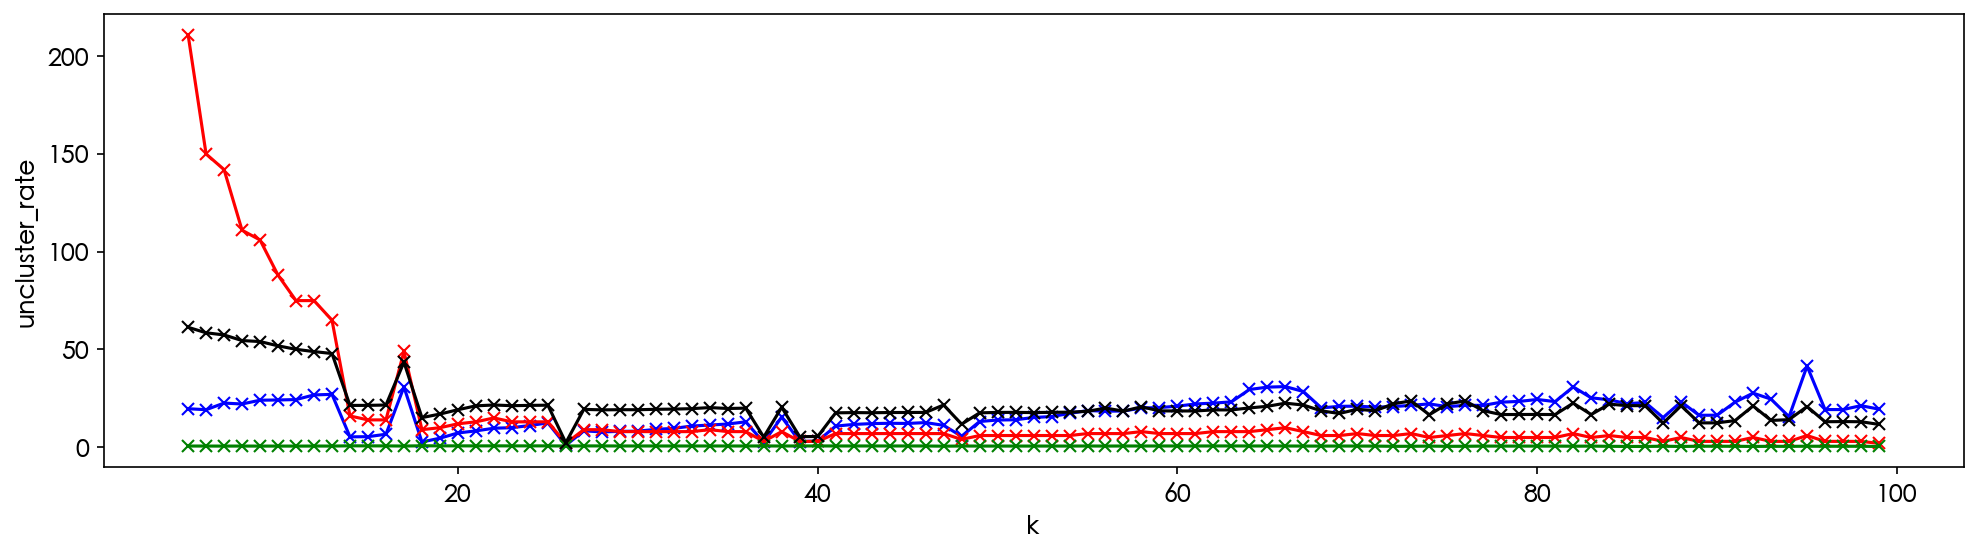

In [296]:
# !pip install hdbscan
from collections import Counter
import hdbscan
import matplotlib.pyplot as plt

unclustered_ratio = []
n_clusters = []
ginis = []
entropies = []
K = range(5, 100)
for k in K:
    cluster = hdbscan.HDBSCAN(
        min_cluster_size=k,
        metric='euclidean',                      
        cluster_selection_method='eom').fit(tsne_embeddings)
    
    cluster_counter = Counter(list(cluster.labels_))
    unclustered_ratio.append(cluster_counter[-1]/tsne_embeddings.shape[0])
    n_clusters.append(len(cluster_counter)-1)
    ginis.append(gini_coefficient(cluster_counter))
    entropies.append(calculate_entropy(cluster_counter))
    print(k, end=" ")

plt.figure(figsize=(16, 4), dpi=150)
plt.plot(K, [r*100 for r in unclustered_ratio], 'bx-')
plt.plot(K, n_clusters, 'rx-')
plt.plot(K, ginis, 'gx-', label="gini")
plt.plot(K, [e*10 for e in entropies], 'kx-', label="entropy")
plt.xlabel('k')
plt.ylabel('uncluster_rate')
plt.show()

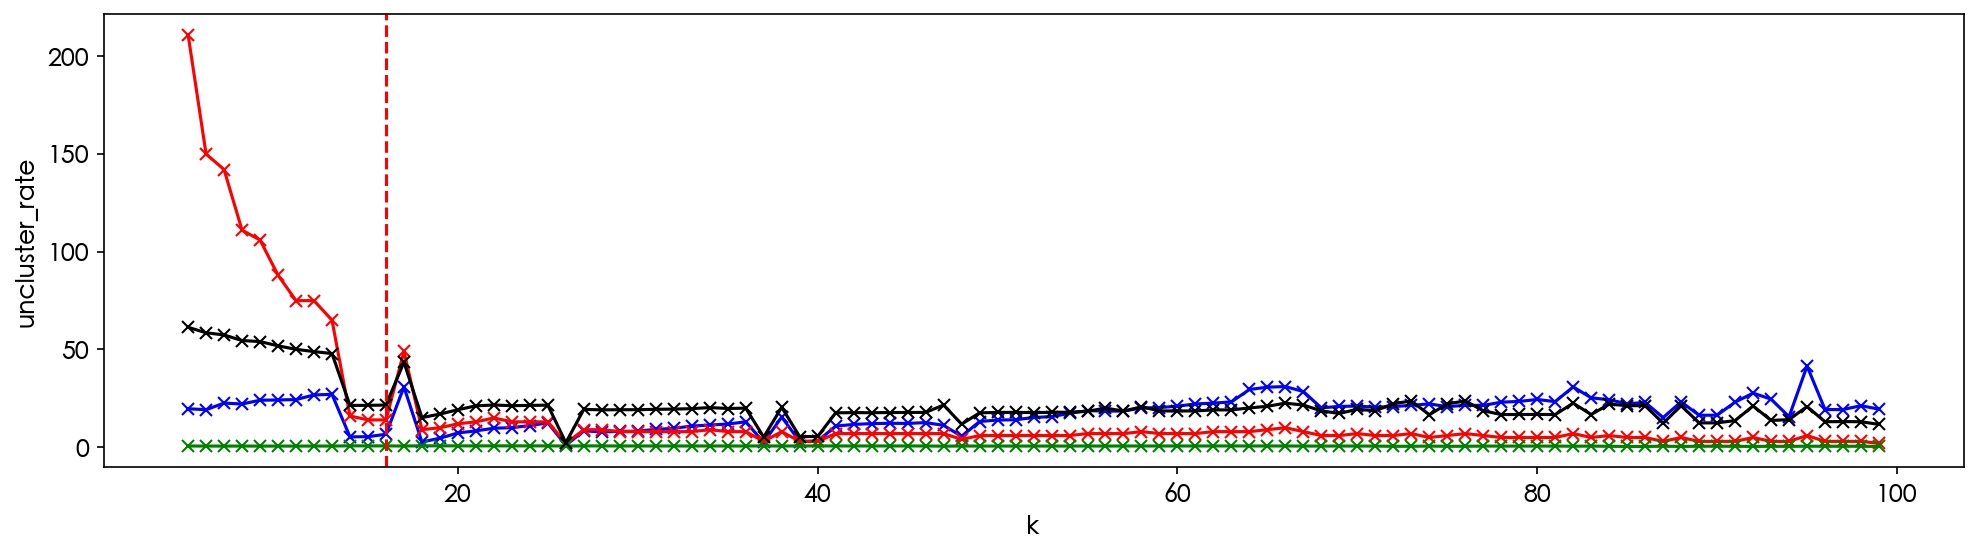

In [297]:
plt.figure(figsize=(16, 4), dpi=150)
plt.plot(K, [u*100 for u in unclustered_ratio], 'bx-')
plt.plot(K, n_clusters, 'rx-')
plt.plot(K, ginis, 'gx-', label="gini")
plt.plot(K, [e*10 for e in entropies], 'kx-', label="entropy")
plt.axvline(x=16, color='r', linestyle='--')
plt.xlabel('k')
plt.ylabel('uncluster_rate')
plt.show()


In [298]:
# !pip install hdbscan
import hdbscan
from collections import Counter

cluster = hdbscan.HDBSCAN(
    min_cluster_size= 16,
    metric='euclidean',                      
    cluster_selection_method='eom').fit(tsne_embeddings)

df['cluster'] = list(cluster.labels_)
print(df.columns)
print(Counter(df['cluster']))

Index(['tag', 'text', 'token_text', 'cleaned', 'cluster'], dtype='object')
Counter({13: 4144, -1: 425, 11: 409, 6: 214, 12: 201, 4: 154, 1: 141, 10: 128, 9: 116, 8: 115, 7: 100, 2: 84, 3: 61, 0: 54, 5: 42})


In [217]:
df

,tag,text,token_text,cleaned,cluster
0,P,店家很給力，快遞也是相當快，第三次光顧啦,"[店家, 很, 給力, ，, 快遞, 也, 是, 相當快, ，, 第三次, 光顧, 啦]","[店家, 給力, 快遞, 相當快, 第三次, 光顧]",11
1,N,這樣的配置用Vista系統還是有點卡。 指紋收集器。 沒送原裝滑鼠還需要自己買，不太好。,"[這樣, 的, 配置, 用, Vista, 系統, 還是, 有點, 卡, 。, , 指紋,...","[配置, Vista, 系統, 有點, 卡, 指紋, 收集器, 沒送, 原裝, 滑鼠, 需要...",11
2,P,不錯，在同等檔次酒店中應該是值得推薦的！,"[不錯, ，, 在, 同等, 檔次, 酒店, 中應, 該, 是, 值得, 推薦, 的, ！]","[不錯, 同等, 檔次, 酒店, 中應, 值得, 推薦]",4
3,N,哎！ 不會是蒙牛乾的吧 嚴懲真凶！,"[哎, ！, , 不會, 是, 蒙牛, 乾, 的, 吧, , 嚴懲, 真凶, ！]","[蒙牛, 乾, 嚴懲, 真凶]",9
4,N,空尤其是三立電視臺女主播做的序尤其無趣像是硬湊那麼多字,"[空, 尤其, 是, 三立, 電視, 臺, 女主播, 做, 的, 序, 尤其, 無趣, 像是...","[空, 尤其, 三立, 電視, 臺, 女主播, 做, 序, 尤其, 無趣, 像是, 硬, 湊...",11
...,...,...,...,...,...
6383,P,價效比高、記憶體大、功能全，螢幕超清晰,"[價效, 比高, 、, 記憶體, 大, 、, 功能, 全, ，, 螢幕超, 清晰]","[價效, 比高, 記憶體, 功能, 全, 螢幕超, 清晰]",6
6384,N,你太狠了… 告訴你他們不會喧譁的人，肯定是蒙牛喝多了,"[你, 太狠, 了, …, , 告訴, 你, 他們, 不會, 喧, 譁, 的, 人, ，,...","[太狠, 告訴, 喧, 譁, 人, 肯定, 蒙牛, 喝多]",11
6385,N,醫生居然買了蒙牛，我是喝呢還是不喝呢還是不喝呢？,"[ , 醫生, 居然, 買, 了, 蒙牛, ，, 我, 是, 喝, 呢, 還是, 不, 喝,...","[醫生, 買, 蒙牛, 喝, 喝, 喝]",11
6386,N,我只想說 夾蒙牛是不對的 販賣毒品是犯罪行為,"[我, 只, 想, 說, , 夾, 蒙牛, 是, 不, 對, 的, , 販賣, 毒品, ...","[只, 想, 說, 夾, 蒙牛, 販賣, 毒品, 犯罪, 行為]",11


### Plotting

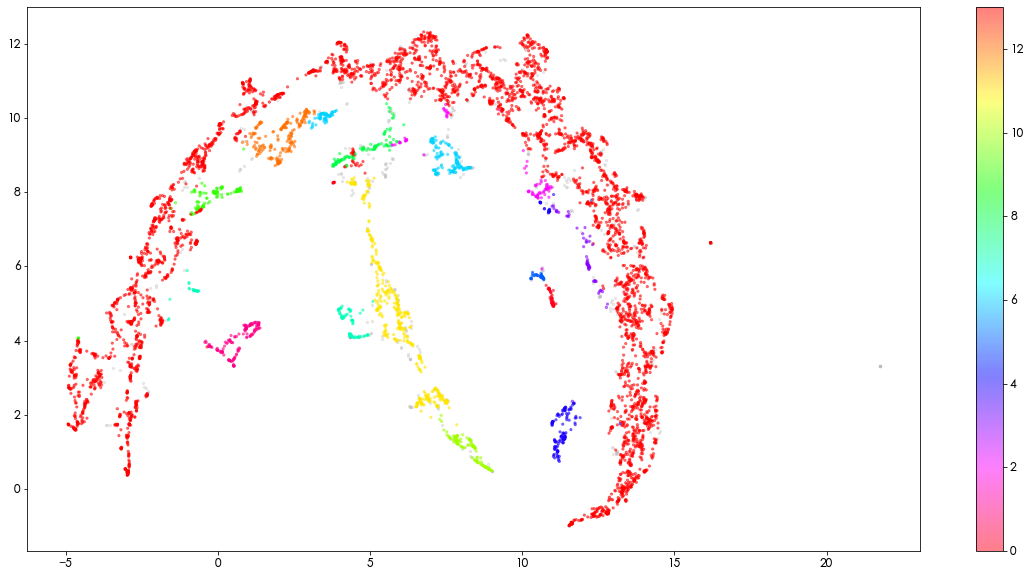

In [299]:
import matplotlib.pyplot as plt

# Prepare data
# Reduce original data to two dimensions
umap_data = umap.UMAP(
    n_neighbors=10, 
    n_components=2, 
    min_dist=0.0, 
    metric='euclidean').fit_transform(X)

# Combine x and y and cluster label
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.3)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, alpha=0.5, cmap='hsv_r')
plt.colorbar()

In [300]:
import unicodedata # for removing Chinese puctuation
# !wget https://github.com/P4CSS/PSS/raw/master/data/stopwords_zh-tw.txt -O stopwords_zh-tw.txt
def remove_stopWords(words):
    with open("stopwords_zh-tw.txt", encoding="utf-8") as fin:
        stopwords = fin.read().split("\n")[1:]
    out = []
    for word in words:
        if word not in stopwords:
            out.append(word)
    return out
def remove_punc_by_unicode(words):
    out = []
    for word in words:
        if word != " " and not unicodedata.category(word[0]).startswith('P'):
            out.append(word)
    return out
df['cleaned'] = df['token_text'].apply(remove_punc_by_unicode).apply(remove_stopWords)

In [301]:
from collections import defaultdict, Counter
clu_counter = Counter(df['cluster'])
cdict = defaultdict(Counter)
for k, v in zip(df['cluster'], df['cleaned']):
    for word in v:
        cdict[k][word] += 1
for c in cdict:
    print("-"*80)
    print("Cluster", c, "has", clu_counter[c], "members")
    print(cdict[c].most_common(20))

--------------------------------------------------------------------------------
Cluster 13 has 4144 members
[('蒙牛', 1315), ('好', 743), ('不錯', 584), ('買', 415), ('喝', 290), ('說', 274), ('感覺', 253), ('酒店', 228), ('房間', 218), ('喜歡', 181), ('後', 180), ('系統', 172), ('價效', 172), ('外觀', 171), ('價格', 170), ('書', 167), ('太', 163), ('方便', 156), ('人', 156), ('有點', 149)]
--------------------------------------------------------------------------------
Cluster 6 has 214 members
[('好', 52), ('不錯', 36), ('有點', 25), ('買', 23), ('酒店', 20), ('價格', 20), ('說', 19), ('感覺', 16), ('後', 14), ('配置', 14), ('螢幕', 13), ('問題', 12), ('小', 12), ('時間', 11), ('一個', 11), ('房間', 10), ('系統', 10), ('方便', 10), ('速度', 10), ('驅動', 10)]
--------------------------------------------------------------------------------
Cluster 11 has 409 members
[('好', 55), ('買', 51), ('酒店', 47), ('不錯', 46), ('房間', 45), ('說', 44), ('書', 35), ('不好', 27), ('感覺', 26), ('後', 25), ('太', 24), ('人', 23), ('系統', 21), ('方便', 18), ('差', 16), ('一個', 16), (

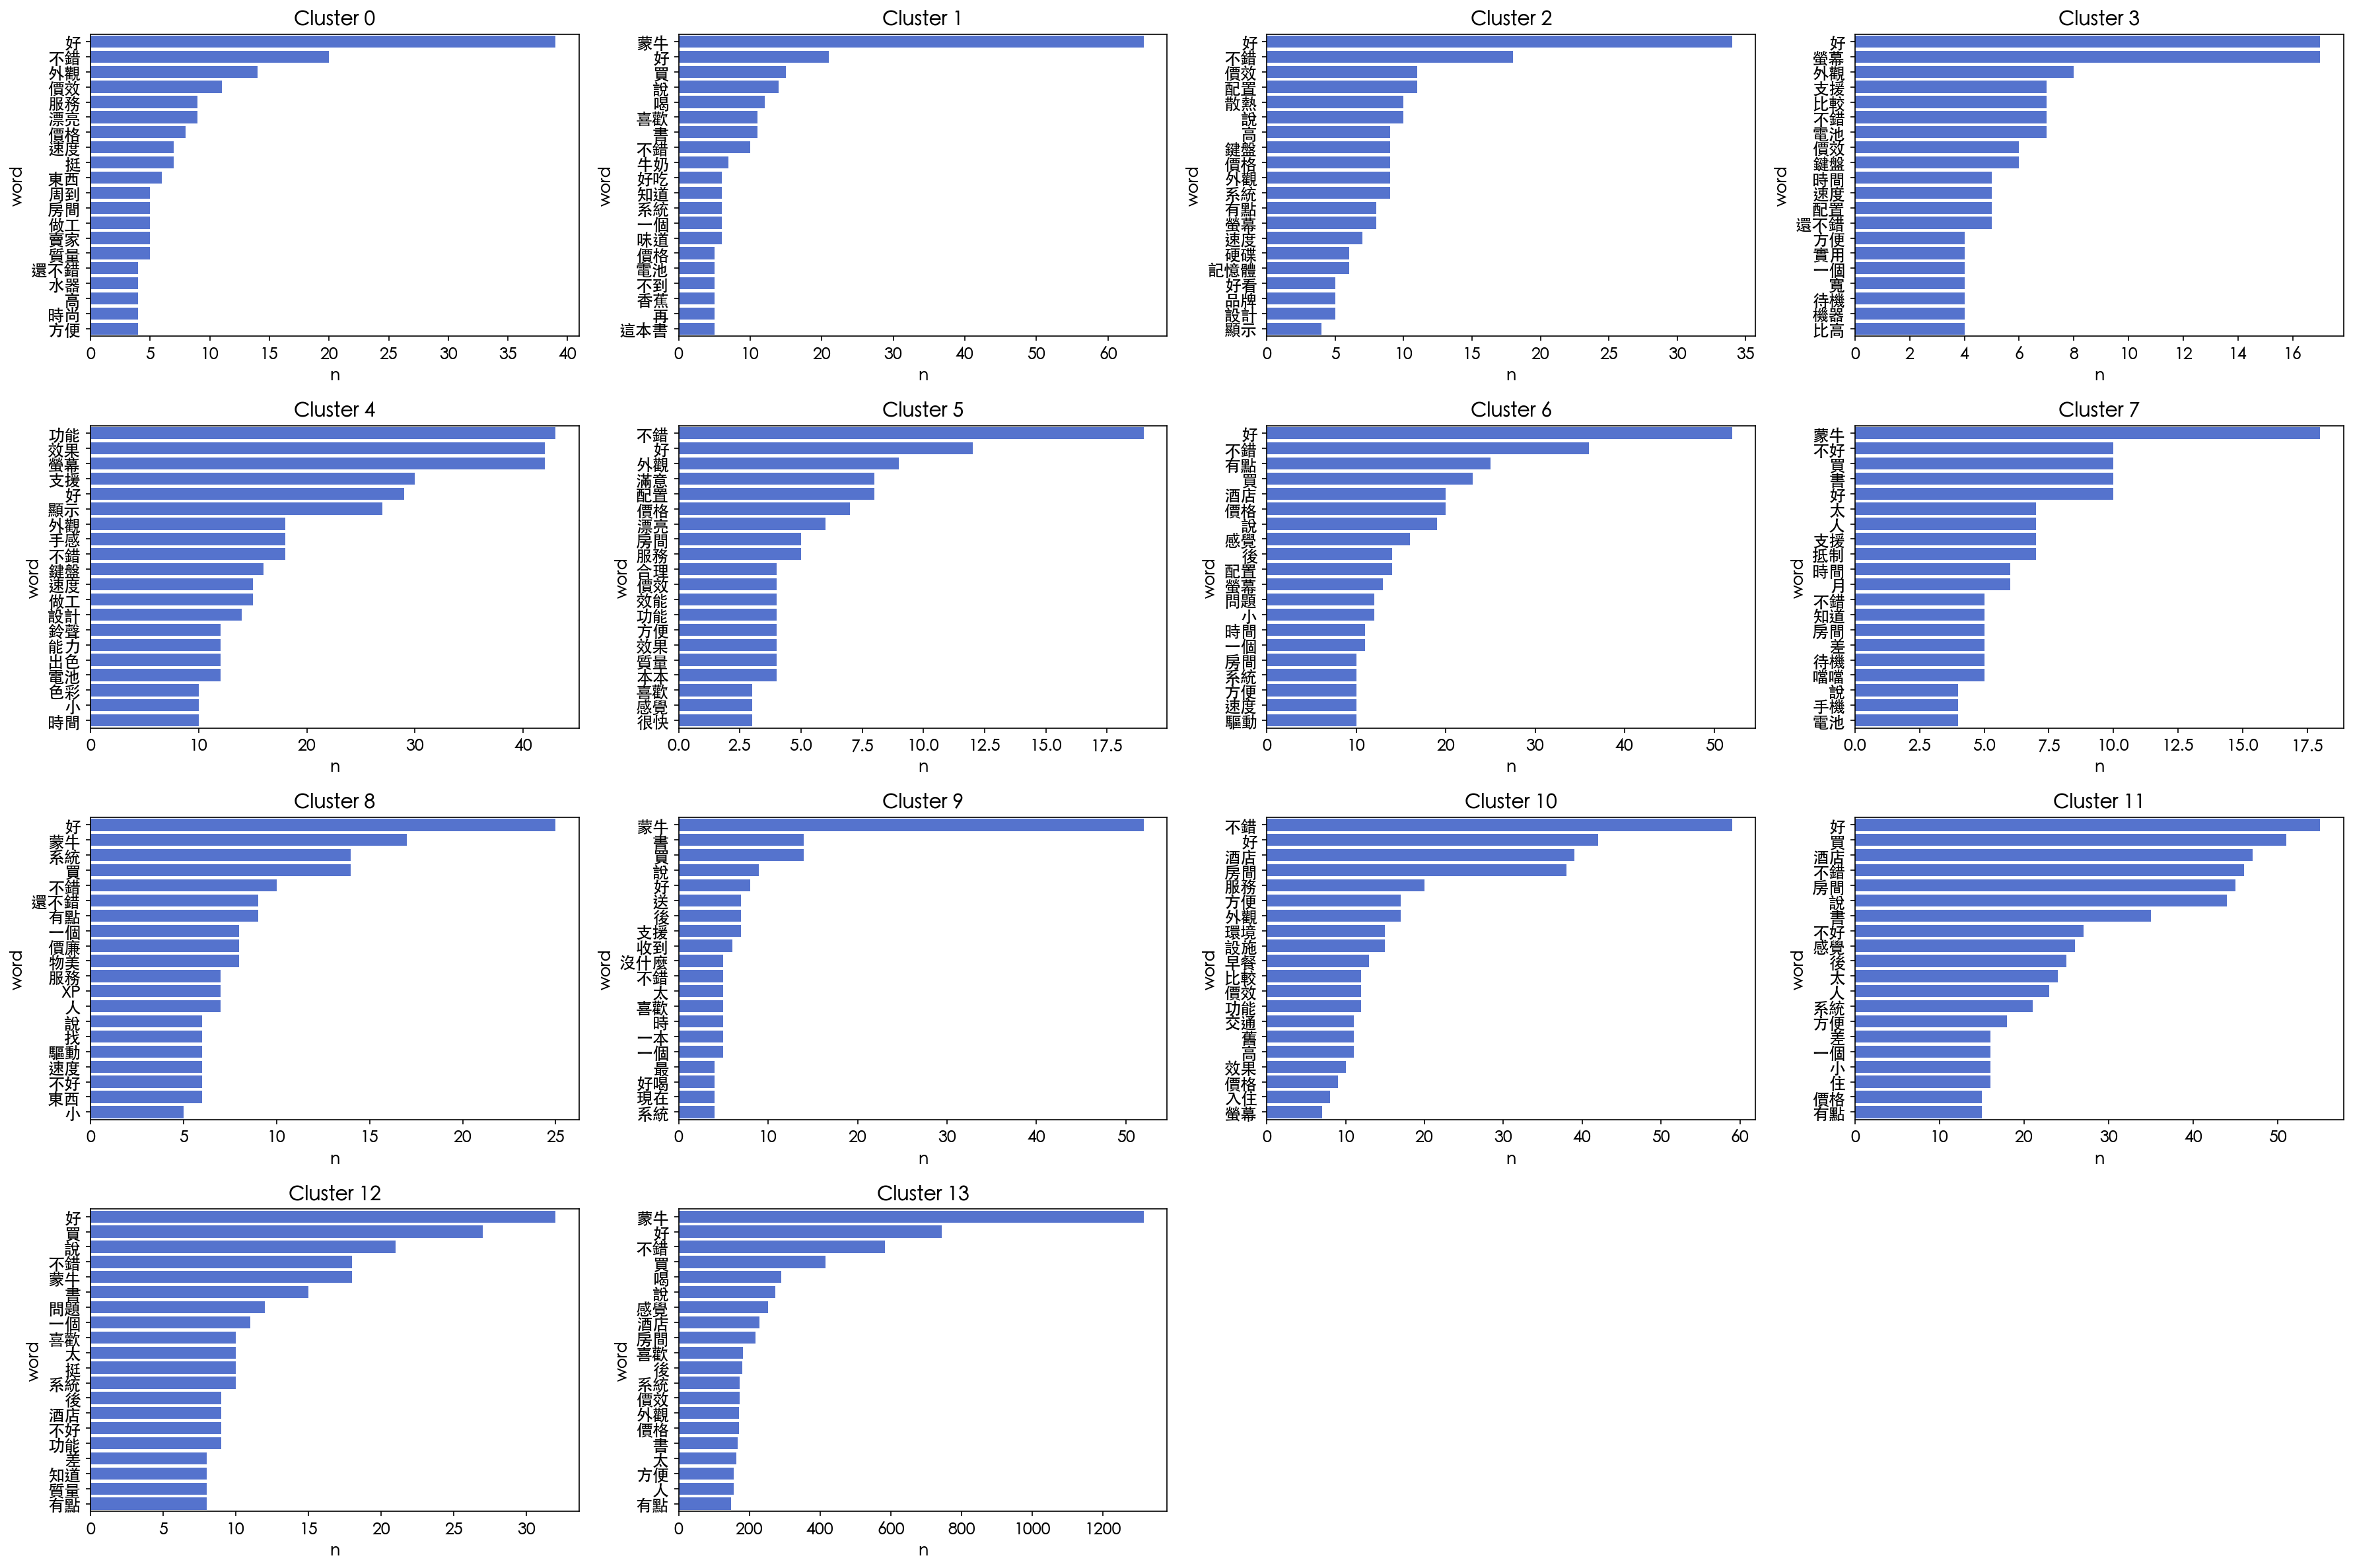

In [302]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Number of columns for subplots
num_columns = 4

# Total number of clusters
num_clusters = len(clu_counter) - 1

# Calculate the number of rows needed
num_rows = num_clusters // num_columns + (num_clusters % num_columns > 0)

# Create a figure with subplots
plt.figure(figsize=(6 * num_columns, 4 * num_rows), dpi=150)

for clu in range(num_clusters):
    # Create a subplot in the appropriate grid position
    plt.subplot(num_rows, num_columns, clu + 1)

    # Create a DataFrame for the current cluster
    df1 = pd.DataFrame(list(cdict[clu].most_common(20)), columns=['word', 'n'])
    
    # Sort the data
    df_data = df1.sort_values('n', ascending=False)

    # Plot the data
    sns.barplot(x='n', y='word', data=df_data, label='word', color='royalblue')

    # Optionally, add a title for each subplot
    plt.title(f"Cluster {clu}")

# Adjust the layout
plt.tight_layout()
plt.show()


In [76]:
"""
import seaborn as sns
for clu in range(len(clu_counter)-1):
    df1 = pd.DataFrame(list(cdict[clu].most_common(20)), columns = ['word', 'n'])
    plt.figure(figsize=(6, 4), dpi=150) 
    df_data = df1.sort_values('n', ascending=False)
#     print(df_data)
    sns.barplot(x='n', 
                y='word', 
                data=df_data, 
                label='word', 
                color='royalblue',
               )
"""

"\nimport seaborn as sns\nfor clu in range(len(clu_counter)-1):\n    df1 = pd.DataFrame(list(cdict[clu].most_common(20)), columns = ['word', 'n'])\n    plt.figure(figsize=(6, 4), dpi=150) \n    df_data = df1.sort_values('n', ascending=False)\n#     print(df_data)\n    sns.barplot(x='n', \n                y='word', \n                data=df_data, \n                label='word', \n                color='royalblue',\n               )\n"